In [2]:
from __future__ import print_function
import sys
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import *
import numpy as np


In [3]:
sc = SparkContext()
lines = sc.textFile("taxi-data-sorted-small.csv.bz2")
taxilines = lines.map(lambda x: x.split(','))

In [4]:
def correctRows(p):
    '''This function checks if the line has 17 values and have conditions for the time, distance, toll and total
    distance.'''
    if (len(p) == 17):
        if (isfloat(p[5]) and isfloat(p[15]) and isfloat(p[4]) and isfloat(p[16])):
            if (float(p[4]) > 10 and float(p[4]) < 86400):
                if (float(p[5]) > 0 and float(p[5]) < 1000):
                    if (float(p[15]) >= 0 and float(p[15]) < 2000):
                        if (float(p[16]) > 1 and float(p[16]) < 600):
                            return p


def isfloat(value):
    '''This function checks if the value is float or not'''
    try:
        float(value)
        return True
    except:
        return False


In [6]:
# applying the function to the rows of data
taxilinesCorrected = taxilines.filter(correctRows)

spark = SparkSession.builder.getOrCreate()
new_df = taxilinesCorrected.map(lambda x: (x[1],x[2],float(x[4]),float(x[5]),float(x[15]),float(x[16])))

#creating data frame with relevant column names
df = spark.createDataFrame(new_df, ['driver', 'date', 'time_seconds', 'distance_miles', 'tolls', 'total'])

#splitting the date and time using delimiter as ' '
df1 = df.withColumn('dates', split(df['date'], ' ').getItem(0)) \
    .withColumn('times', split(df['date'], ' ').getItem(1))

#splitting the hour in times using delimiter as ':'
df2 = df1.withColumn('hr', split(df1['times'], ':').getItem(0))

#finding if it is a night ride or not
df3 = df2.withColumn('night', f.when((df2["hr"] >= 1) & (df2["hr"] < 6), 1).otherwise(0))

#converting from time in hours to seconds
df4 = df3.withColumn('time_hours', df3['time_seconds'] / 3600)

#grouping by dates and driver, and calculating respective fields asked in the question
df5 = df4.groupBy(["dates", "driver"]).agg(
    {'time_hours': 'sum', 'distance_miles': 'sum', 'tolls': 'sum', 'times': 'count', 'night': 'sum',
     'total': 'sum'})

#remove irrelevant columns
df6 = df5.drop("dates", "driver")

#updating the column names
df7 = df6.withColumnRenamed("sum(time_hours)", "working_time_hours") \
    .withColumnRenamed("sum(night)", "night_count") \
    .withColumnRenamed("sum(distance_miles)", "working_distance") \
    .withColumnRenamed("sum(total)", "total_amount") \
    .withColumnRenamed("sum(tolls)", "toll_amounts") \
    .withColumnRenamed("count(times)", "all_count")




In [7]:
df7.show(3)

+------------------+------------+-----------+------------------+------------------+---------+
|working_time_hours|toll_amounts|night_count|  working_distance|      total_amount|all_count|
+------------------+------------+-----------+------------------+------------------+---------+
| 6.733333333333332|         4.8|          8|             99.55|             477.0|       34|
| 5.383333333333334|         4.8|         23| 88.51000000000002|424.29999999999995|       35|
|3.5666666666666673|         0.0|         12|47.519999999999996|            223.35|       15|
+------------------+------------+-----------+------------------+------------------+---------+
only showing top 3 rows



In [8]:
#convert into an RDD
myRDD = df7.rdd.map(tuple)

#vectorization for predictors
myRDD = myRDD.map(lambda x: (float(x[4]), np.array([(x[0]), x[1], x[2], x[3], x[5]])))
print(myRDD.take(2))

#calculating the size
size = myRDD.count()

myRDD.cache()


[(477.0, array([ 6.73333333,  4.8       ,  8.        , 99.55      , 34.        ])), (424.29999999999995, array([ 5.38333333,  4.8       , 23.        , 88.51      , 35.        ]))]


PythonRDD[22] at RDD at PythonRDD.scala:53

In [7]:
size

120029

In [9]:
#initialization parameters
num_iteration = 200
beta = np.ones(5)
learningRate = 0.00001
precision = 0.01
cost_all = []



for i in range(num_iteration):

    #code for gradient descent
    gradientCost = myRDD.map(lambda x: (x[1], (x[0] - np.dot(x[1], beta)))) \
        .map(lambda x: (x[0] * x[1], x[1] ** 2)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

    cost = gradientCost[1]

    gradient = (-1 / float(size)) * gradientCost[0]

    print("Iteration: ", i, " Beta: ", beta, " Cost: ", cost)
    beta = beta - learningRate * gradient

    #containing all costs for all iterations
    cost_all.append(cost)

    if i != 0:
            
            
        #implementing bold driver

        #finding the the current and previous cost, and comparing
        #learning rate halves if cost increases
        #learning rate is increases 1.05 times if cost decreases
        cost_current = cost_all[i]
        cost_previous = cost_all[i-1]
        
        #stopping criteria for precision
        if np.abs(cost_current - cost_previous) < precision:
            break
            
        if (cost_current > cost_previous):
            learningRate = learningRate * 0.5
            continue

        if (cost_current < cost_previous):
            learningRate = learningRate * 1.05
            continue



Iteration:  0  Beta:  [1. 1. 1. 1. 1.]  Cost:  4081040584.888015
Iteration:  1  Beta:  [1.00662644 1.0080077  1.00264174 1.10145425 1.03503011]  Cost:  3806694138.370999
Iteration:  2  Beta:  [1.01302626 1.01571735 1.00518603 1.19928167 1.06887876]  Cost:  3551500500.7504134
Iteration:  3  Beta:  [1.01951656 1.02351068 1.00775885 1.29832769 1.10322338]  Cost:  3302478647.1014442
Iteration:  4  Beta:  [1.02608734 1.03137278 1.01035537 1.39842073 1.13801299]  Cost:  3060384490.347535
Iteration:  5  Beta:  [1.03272764 1.03928743 1.01297034 1.49937359 1.17319174]  Cost:  2825947412.4188595
Iteration:  6  Beta:  [1.03942558 1.04723707 1.01559808 1.60098352 1.20869898]  Cost:  2599860797.889622
Iteration:  7  Beta:  [1.04616837 1.05520288 1.01823249 1.70303258 1.24446936]  Cost:  2382772400.4274964
Iteration:  8  Beta:  [1.05294231 1.06316478 1.02086706 1.80528811 1.28043299]  Cost:  2175274736.649815
Iteration:  9  Beta:  [1.05973291 1.0711015  1.0234949  1.90750354 1.31651574]  Cost:  1977

Iteration:  78  Beta:  [1.36257029 1.02970988 0.99262028 3.47384062 3.17538897]  Cost:  102255344.94654395
Iteration:  79  Beta:  [1.37058072 1.02443339 0.98828299 3.45751098 3.22571741]  Cost:  100641446.80647182
Iteration:  80  Beta:  [1.37887097 1.01934196 0.98373192 3.44071327 3.27740121]  Cost:  99021630.65872411
Iteration:  81  Beta:  [1.38744579 1.01447632 0.97895734 3.42345089 3.33041946]  Cost:  97399296.68798898
Iteration:  82  Beta:  [1.3963096  1.00988059 0.97394926 3.40572905 3.38474503]  Cost:  95777997.34393813
Iteration:  83  Beta:  [1.40546649 1.00560242 0.96869734 3.38755482 3.4403442 ]  Cost:  94161415.8282722
Iteration:  84  Beta:  [1.41492021 1.00169301 0.96319099 3.36893726 3.49717629]  Cost:  92553340.8279073
Iteration:  85  Beta:  [1.42467411 0.9982072  0.95741936 3.34988757 3.55519335]  Cost:  90957637.50337791
Iteration:  86  Beta:  [1.43473119 0.99520346 0.95137136 3.33041911 3.61433986]  Cost:  89378214.83357397
Iteration:  87  Beta:  [1.44509402 0.99274389 

Iteration:  155  Beta:  [2.00101683 1.69561258 0.50417265 2.62138021 5.54406516]  Cost:  59122095.784423165
Iteration:  156  Beta:  [2.00773943 1.70796676 0.49913409 2.61745497 5.55212815]  Cost:  59045321.9376339
Iteration:  157  Beta:  [2.01476935 1.72079117 0.49391055 2.61342334 5.56035544]  Cost:  58967052.651343726
Iteration:  158  Beta:  [2.02212009 1.73409361 0.48849878 2.60928598 5.56874072]  Cost:  58887355.0061069
Iteration:  159  Beta:  [2.02980571 1.74788074 0.48289588 2.60504384 5.57727687]  Cost:  58806304.438504815
Iteration:  160  Beta:  [2.03784091 1.76215796 0.47709933 2.60069822 5.585956  ]  Cost:  58723984.90018042
Iteration:  161  Beta:  [2.04624104 1.7769292  0.471107   2.59625071 5.59476942]  Cost:  58640488.95043837
Iteration:  162  Beta:  [2.05502214 1.79219676 0.46491728 2.59170326 5.60370763]  Cost:  58555917.77000542
Iteration:  163  Beta:  [2.06420096 1.80796111 0.45852905 2.58705816 5.61276034]  Cost:  58470381.08245184
Iteration:  164  Beta:  [2.07379503 

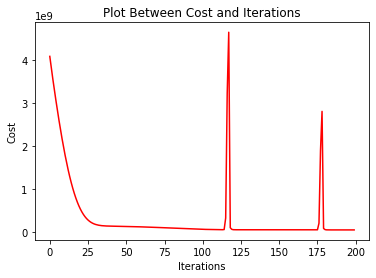

In [10]:
import matplotlib.pyplot as plt

y = cost_all
x = range(len(y))

plt.title("Plot Between Cost and Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.plot(x, y, color ="red")
plt.show()

In [ ]:
sc.stop()